In [1]:
working_dir = '/mnt/c/users/fordd/Downloads/RW_PGM_FE/'
py_files_dir =  working_dir+'py_files/'
saved_arrays_dir = working_dir+'saved_arrays/'
saved_models_dir = working_dir+'saved_models/'
pdb_files_dir = working_dir+'pdb_files/'
trajectory_files_dir = working_dir+'trajectory_files/'

In [2]:
import os

os.chdir(py_files_dir)

from utils import *
from model import *
from IC_MAP import *

os.chdir(working_dir)

In [3]:
T = 300 # K
PDB = pdb_files_dir+'ibuprofen-in-vacuum.pdb'
inds_CVs = [[13, 10, 3, 1], [4, 3, 1, 0]]
FF_name = pdb_files_dir+'ibuprofen-in-vacuum-system.prmtop'

In [4]:
get_labels_ = get_labels_from_CVs_ibuprofen_
#get_labels_ = get_labels_from_CVs_ibuprofen_double_well_

In [6]:
smiv = Single_Molecule_In_Vaccum(PDB,
                                 FF = FF_name,
                                 default_temperature = T)

using app.AmberPrmtopFile
# cpu cores will be used for evaluation: 16


In [7]:
path_dataset = trajectory_files_dir+'IB'+str(T)+'u'

# The current unbiased dataset (not expected to be globally ergodic) is 
# concatenation of multiple initialisations of short simulations (50K+50 frames)
# from the 2 basins, 20 times in each basis. The start of each simulation 
# (50 frames) was removed before concatenating; accounting for approximate 
# equilibration time needed to reach target average temperature (300K). 

# 1M (< 2M) frames (half of available data) imported here.

smiv.load_simulation_data_(path_dataset, n_frames=1000000)

loading ['IB300u_sim_ki_Tu', 'IB300u_sim_ki_u', 'IB300u_sim_ki_xyz']


In [8]:
u_ = Local_PE(
global_potential_energy_function_ = smiv.u_,
clustering_function_ = lambda xyz : get_labels_(get_torsional_CVs_(xyz,inds_CVs)),       
) 
u = smiv.u
xyz = smiv.xyz ; print(xyz.shape)

if None in smiv.s: CVs = get_torsional_CVs_(xyz,inds_CVs)
else:              CVs = smiv.s
if None in smiv.v: metaD_weights = np.ones([len(u),1])
else:              metaD_weights = np.exp(smiv.v)

(1000000, 33, 3)


2024-01-23 12:44:40.126170: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 792000000 exceeds 10% of free system memory.
2024-01-23 12:44:55.987106: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 792000000 exceeds 10% of free system memory.


In [9]:
# uniform weights because data unbiased:
(metaD_weights-1).sum()

0.0

In [10]:
labels = get_labels_(CVs)
n_states = len(set(labels))
inds_states = [np.where(labels==k)[0] for k in range(n_states)]
counts_states = np.array([len(x) for x in inds_states])
print('number of metastable states:',n_states)

number of metastable states: 6


In [12]:
# count_matrix_from_cluster_assigments_(labels)

In [13]:
# known from notebook 'AD_and_IB_WTmetaD_FE_plots'
delta_f_ground_truth  = np.array([0.0242205,  0.00768604, 0.01645141,
                                  0.,         1.31893825, 1.30793731])

In [15]:
# running FE estimates from counts:
delta_f_states = deltaf_states_in_time_(labels,weights=metaD_weights,align=True)

FE estimates of state 1 (often the lowest FE) moved to around 0


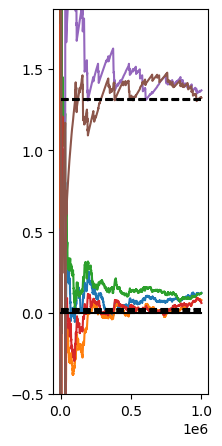

In [16]:
eps = 0.5
fig = plt.figure(figsize=(2,5))

plt.plot(delta_f_states )
plt.plot([0,len(delta_f_states)],[0,0], color='black')
plt.ylim(-eps,delta_f_states[-1].max()+eps)

[plt.plot([0,len(u)],[x]*2,'--',color='black') for x in delta_f_ground_truth]

plt.show()

In [17]:
delta_u_states = deltau_states_in_time_(labels,u,weights=metaD_weights,align=True)
delta_u_states -= delta_u_states[-1].min()
delta_u_GT0 = delta_u_states[-1]
#plt.plot(delta_u_states)
#[plt.plot([0,2e6],[x]*2, color='black') for x in delta_u_GT0]
#plt.ylim(-1,2)

FE estimates of state 3 (often the lowest FE) moved to around 0


/tmp/ipykernel_31395/3542413967.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(-np.log(np.flip(np.histogramdd(CVs,bins=60,range=[[-PI,PI]]*2,density=True)[0].T,axis=0)),cmap='jet')


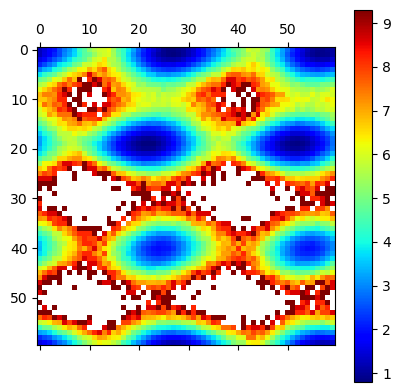

In [18]:
if smiv.FES is None:
    plt.matshow(-np.log(np.flip(np.histogramdd(CVs,bins=60,range=[[-PI,PI]]*2,density=True)[0].T,axis=0)),cmap='jet')
else:
    plt.matshow(np.flip(smiv.FES,axis=0),cmap='jet')
plt.colorbar()

In [18]:
ic_map = XR_MAP_mixed_only(PDB)
xyz = ic_map.align_data_(xyz,
                         eps_singularity = [1e-6,1e-6],
                         )
xyz.shape

full IC would be possible
next run align_data_(R_data)
inds_keep_cartesian: [6 5 7]
These indices work. All atoms can be reached.
# variables static:    6
# variables isotropic: 0
# variables flowing:   93
# total variables 99


(1000000, 33, 3)

In [21]:
# same IC_map as in 2M dataset ('big data'), to be consistent.
ic_map.CSR_obj.overwrite_this_(saved_arrays_dir+'IB300u_CSR_params')

cartesian atoms (from which 6 dof are removed) via alignment: [5 6 7]
n_hydrogens 18


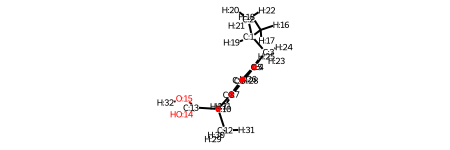

In [22]:
print('cartesian atoms (from which 6 dof are removed) via alignment:',ic_map.inds_XYZ)
print('n_hydrogens',ic_map.n_hydrogens)
ic_map.mol

True


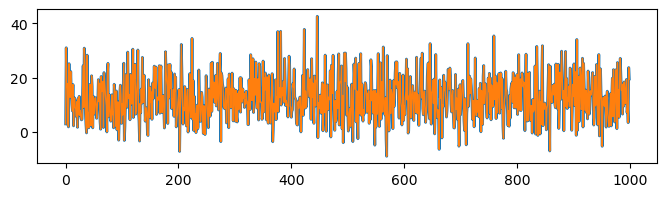

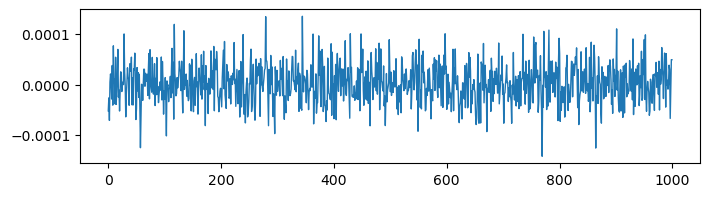

In [23]:
# check that alligned data has the same potential enregies as saved during simulation.
N_total = xyz.shape[0]
rand_inds = np.random.choice(N_total,1000,replace=False)
fig = plt.figure(figsize=(8,2))
plt.plot(u_(xyz[rand_inds]), linewidth=2)
plt.plot(u[rand_inds], linewidth=1)
print(np.allclose(u_(xyz[rand_inds]), u[rand_inds], atol=1e-4))
plt.show()
fig = plt.figure(figsize=(8,2))
plt.plot(u[rand_inds] - u_(xyz[rand_inds]), linewidth=1)
plt.show()

In [24]:
print('counts_states:',counts_states)
training_set_size = min(counts_states)//2
print('size of the training and validation sets:', training_set_size)

counts_states: [212631 222402 213262 226473  61181  64051]
size of the training and validation sets: 30590


0 : 0.027168217493968454 < 0.04


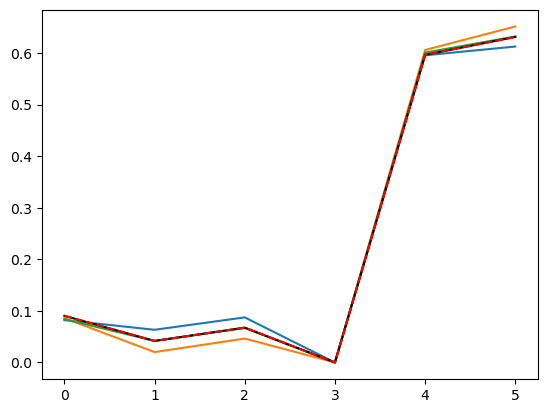

In [24]:
av_u_GT0 = np.array([u[inds_states[k]].mean() for k in range(n_states)])
av_u_GT0 -= av_u_GT0.min()

done = False
for i in range(1000):
    if not done:
        _inds_rand = None
        _inds_rand = load_pickle_(saved_arrays_dir+'_inds_rand_IB300u_6well') # 227 0.04
        #_inds_rand = load_pickle_(saved_arrays_dir+'_inds_rand_IB300u_6well_2m') # 201 0.027
        training, validation, _inds_rand = split_into_training_data_(xyz,u,metaD_weights,
                                            labels=labels,
                                            training_set_size=training_set_size,
                                            inds_rand = _inds_rand)
        xyz_training, u_training, w_training = training
        xyz_validation, u_validation, w_validation = validation
        del training, validation 

        av_u_T = np.array([pool_(u_training[k],w_training[k]) for k in range(n_states)])
        av_u_T -= av_u_T.min()
        av_u_V = np.array([pool_(u_validation[k],w_validation[k]) for k in range(n_states)])
        av_u_V -= av_u_V.min()
        av_u_GT = (av_u_V+av_u_T)*0.5
        av_u_GT -= av_u_GT.min()
        ##
        err = (np.linalg.norm(av_u_GT0-av_u_GT) + np.linalg.norm(av_u_GT0-av_u_T) + np.linalg.norm(av_u_GT0-av_u_V) )/3
        err_max = 0.04 #0.027
        if err <= err_max:
            done = True
            print(i,':',err,'<',err_max)
        else:
            done = False
            print(i,':',err)

plt.plot(av_u_T)
plt.plot(av_u_V)
plt.plot(av_u_GT)
plt.plot(av_u_GT0 - av_u_GT0.min(),color='black')
plt.plot(delta_u_GT0,'--',color='red')
plt.show()

w_training = [x/x.sum() for x in w_training]
w_validation = [x/x.sum() for x in w_validation]

In [25]:
#save_pickle_([xyz_training, u_training, w_training, xyz_validation, u_validation, w_validation],
#            'IB300u_MEMORY')

In [28]:
training_set_size, xyz_training[0].shape[0]

(30590, 30590)

In [29]:
print([x.shape for x in xyz_training])
print([x.shape for x in xyz_validation])

print([x.shape for x in u_training])
print([x.shape for x in u_validation])

print([x.shape for x in w_training])
print([x.shape for x in w_validation])

[(30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3)]
[(30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3), (30590, 33, 3)]
[(30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1)]
[(30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1)]
[(30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1)]
[(30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1), (30590, 1)]


In [30]:
inds_rand = np.random.choice(training_set_size,100,replace=False)

for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-2))
    
k=0
for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-2))
    k+=1

True
True
True
True
True
True
True
True
True
True
True
True


In [31]:
def plot_check_(xyz_tv, w_tv = None):
    n_states = len(xyz_tv)
    if w_tv is None: w_tv = [None]*n_states
    else: w_tv = [x.flatten() for x in w_tv]
    for k in range(n_states):
        hist = np.histogramdd(get_torsional_CVs_(xyz_tv[k],inds_CVs),
                              bins=60,
                              range = [[-PI,PI]]*2,
                              weights=w_tv[k],
                              density=True,
                             )[0]
        hist /= hist.sum()
        hist = np.where(hist==0.0,np.nan,hist)
        plt.contour(hist.T, cmap='jet', levels=50)#, colors='C'+str(k), levels=5)
    plt.colorbar()

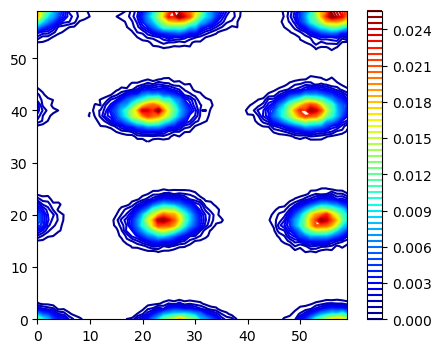

In [32]:
fig = plt.figure(figsize=(5,4))
plot_check_(xyz_training)
plt.show()

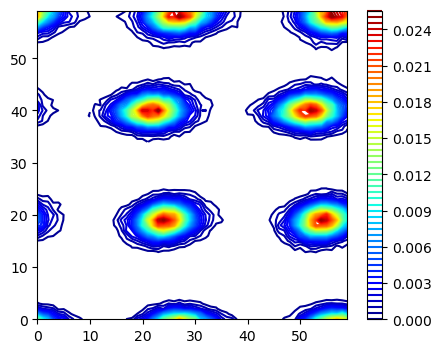

In [33]:
fig = plt.figure(figsize=(5,4))
plot_check_(xyz_training, w_training)
plt.show()

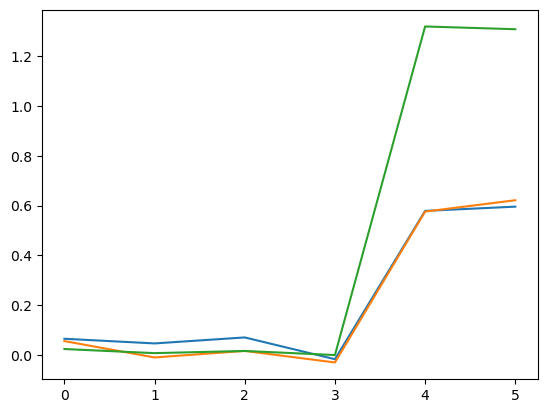

In [34]:
plt.plot([pool_(u_training[k],w_training[k])-12.6 for k in range(n_states)])
plt.plot([pool_(u_validation[k],w_validation[k])-12.6 for k in range(n_states)])
plt.plot(delta_f_ground_truth)

In [35]:
PM = ic_map.CSR_obj.periodic_mask
flow_masks = get_list_cond_masks_unsupervised_(len(PM)) ; print(len(flow_masks))
flow_masks = get_random_flow_masks_(len(PM),4) ; print(len(flow_masks))

7
4


In [42]:
PM = ic_map.CSR_obj.periodic_mask
flow_masks = load_pickle_(saved_arrays_dir+'random_flow_masks_IB_(use_in_all_IB)') ; print(len(flow_masks))

4


-0.99999934 >=-1 0.99999964 <=1 0.00029430084 ~0


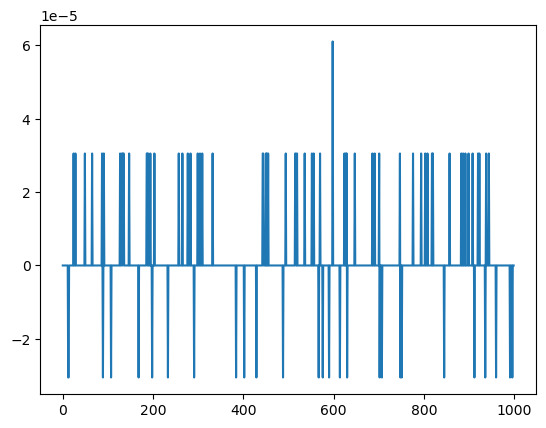

In [43]:
# all these extra steps are due to 2M conformers taking up too much tf(GPU) memory.
# checking that ic_map has the correct ranges and data is aligned after
# loading those parameters manually:

r = np.array(xyz_validation[0][np.random.choice(training_set_size,1000,replace=False)])

x, ladrx = ic_map.forward(r.astype(np.float32))
_r, ladJxr = ic_map.inverse(x)

print(x.numpy().min(),'>=-1', x.numpy().max(),'<=1', tf.norm(ladrx+ladJxr).numpy(),'~0')
plt.plot(ladrx+ladJxr)
plt.show()

In [46]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [47]:
learning_rate = 0.001 #0.0003
rate_decay = 0.000001

In [48]:
for k in range(n_states):
    globals()['model_'+str(k)] = MODEL_3(periodic_mask = PM,
                                    list_cond_masks = flow_masks,
                                    IC_map = ic_map,
                                    optimiser_LR_decay = [learning_rate, rate_decay],

                                    n_bins_periodic = 8,
                                    number_of_splines_periodic = 2,
                                    n_bins_other = 8,

                                    n_hidden = 2, # 1
                                    hidden_activation = tf.nn.silu,
                                    min_bin_width = 1e-3,
                                    trainable_slopes = True,
                                    min_knot_slope = 1e-3,
                                    dims_hidden = None,
                                    nk_for_periodic_MLP_encoding = 1,
                                    )

There are 34153996 trainable parameters in this model, among 64 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 34153996 trainable parameters in this model, among 64 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 34153996 trainable parameters in this model, among 64 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 34153996 trainable parameters in this model, among 64 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 34153996 trainable parameters in this model, among 64 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 34153996 trainable parameters in this model, 

In [49]:
trainer = TRAINER(models = [globals()['model_'+str(k)] for k in range(n_states)],
        max_training_batches = 150000,
        n_batches_between_evaluations = 50,
       )

FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 1 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 1 (often the lowest FE) moved to around 0


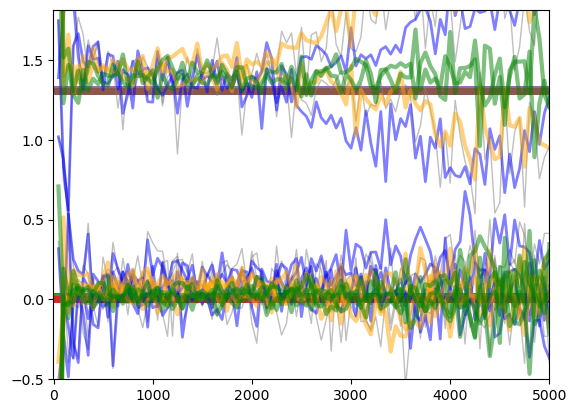

In [39]:
trainer.train(
            n_batches = 5000,
    
            training_batch_size = 1000,
            evalation_batch_size = 10000,
    
            xyz_training = xyz_training,
            u_training = u_training,
            xyz_validation = xyz_validation,
            u_validation = u_validation,
    
            potential_energy_function = u_,
            
            delta_f_ground_truth = delta_f_ground_truth,
            
            evaluate_main = True,
            f_window_grain_BAR_local = [-50,50,2000],
            shuffle = True,
    
            name_save_BAR_inputs = saved_arrays_dir+'IB300u_BAR_inputs_I6W',
            name_save_mBAR_inputs = saved_arrays_dir+'IB300u_MBAR_inputs_I6W',
)

In [40]:
trainer.save_the_above_(saved_arrays_dir+'IB300u_est_grid_AVall_I6W')

saved IB300u_est_grid_AVall_I6W


In [41]:
for k in range(n_states):
    globals()['model_' + str(k)].save_model(saved_models_dir+'model_'+str(k)+'_IB300u_NEW_I6W')

saved model_0_IB300u_NEW_I6W
saved model_1_IB300u_NEW_I6W
saved model_2_IB300u_NEW_I6W
saved model_3_IB300u_NEW_I6W
saved model_4_IB300u_NEW_I6W
saved model_5_IB300u_NEW_I6W


In [ ]:
## results plotted in a different notebook 'IB300u_mBAR (big data)'

In [50]:
estimates, evaluation_grid = load_pickle_(saved_arrays_dir+'IB300u_est_grid_AVall_I6W')[:2]

FE estimates of state 2 (often the lowest FE) moved to around 0


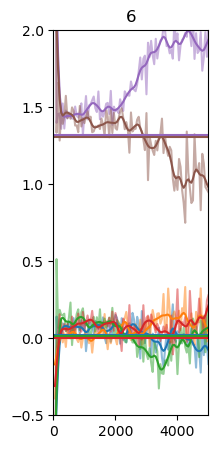

FE estimates of state 1 (often the lowest FE) moved to around 0


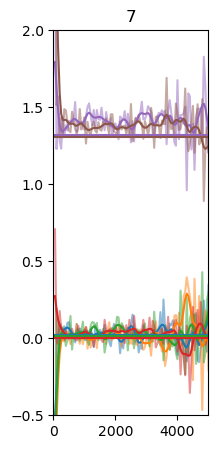

In [51]:
for which in [6,7]:
    start = -100

    x = fs_to_deltafs_(estimates[:,:,which].T, ind_min=None, start=start) # (m,n_states)
    #x-= 0.45
    fig = plt.figure(figsize=(2,5))
    plt.plot(evaluation_grid, x, alpha=0.5)
    [plt.plot(evaluation_grid, simple_smoother_(x[:,k],c=0.6), color='C'+str(k)) for k in range(n_states)]
    [plt.plot([-1,evaluation_grid[-1]],[delta_f_ground_truth[k]]*2, color = 'C'+str(k)) for k in range(n_states)]

    plt.title(which)
    plt.ylim(-0.5,2.)
    plt.xlim(0,evaluation_grid[-1])
    plt.show()

FE estimates of state 0 (often the lowest FE) moved to around 0


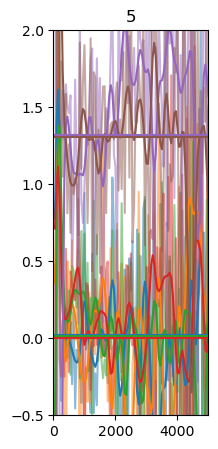

In [53]:
for which in [5]:
    start = -100

    x = fs_to_deltafs_(estimates[:,:,which].T, ind_min=None, start=start) # (m,n_states)
    #x-= 0.45
    fig = plt.figure(figsize=(2,5))
    plt.plot(evaluation_grid, x, alpha=0.5)
    [plt.plot(evaluation_grid, simple_smoother_(x[:,k],c=0.6), color='C'+str(k)) for k in range(n_states)]
    [plt.plot([-1,evaluation_grid[-1]],[delta_f_ground_truth[k]]*2, color = 'C'+str(k)) for k in range(n_states)]

    plt.title(which)
    plt.ylim(-0.5,2.)
    plt.xlim(0,evaluation_grid[-1])
    plt.show()

In [66]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [67]:
rs = []
negS_BGs = []
for k in range(n_states):
    r_samples, negS_BG = trainer.models[k].sample_model(10000)
    rs.append(r_samples)
    negS_BGs.append(negS_BG)
    
ss = [get_torsional_CVs_(r,inds_CVs=inds_CVs) for r in rs]

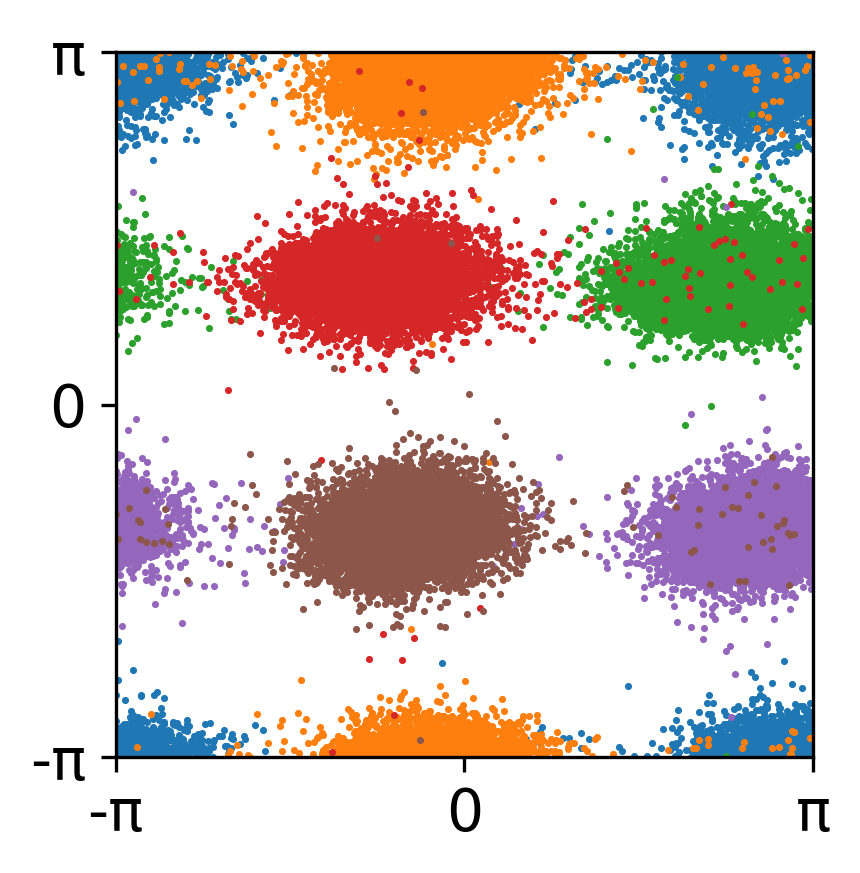

In [44]:
fig = plt.figure(figsize=(3,3.05),dpi=300)
for k in range(n_states):
    plt.scatter(ss[k][:,0],ss[k][:,1],s=0.5)
    
plt.xlim(-PI,PI)
plt.ylim(-PI,PI)
plt.xticks([-PI,0,PI],['-π','0','π'])
plt.yticks([-PI,0,PI],['-π','0','π'])
plt.show()

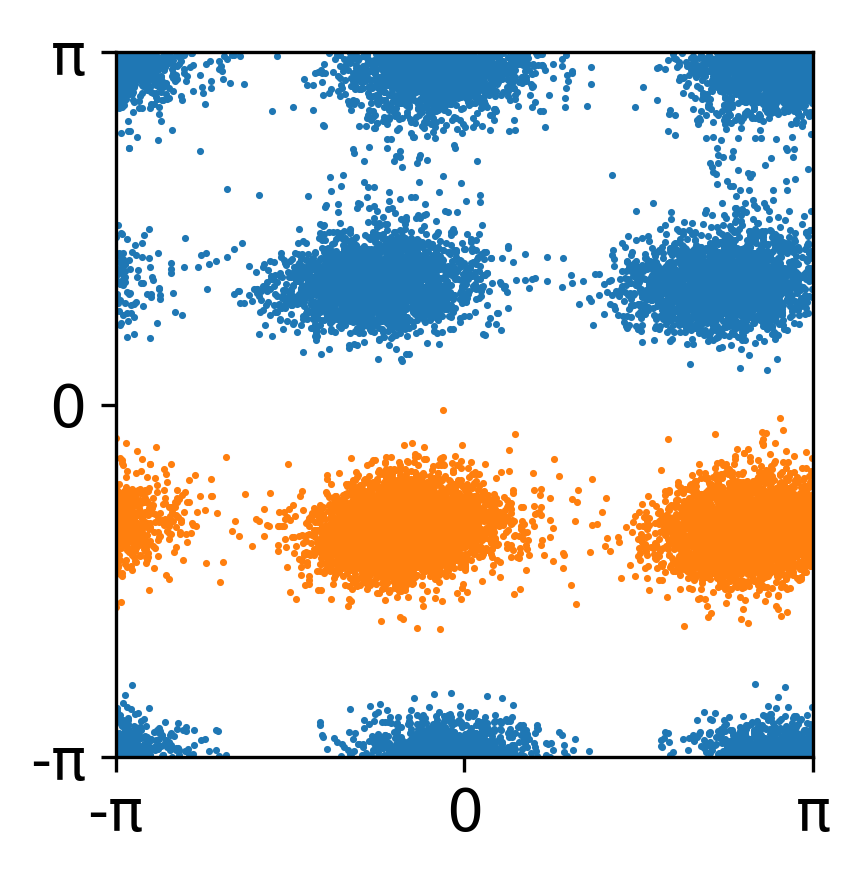

In [65]:
fig = plt.figure(figsize=(3,3.05),dpi=300)
for k in range(n_states):
    plt.scatter(ss[k][:,0],ss[k][:,1],s=0.5)
    
plt.xlim(-PI,PI)
plt.ylim(-PI,PI)
plt.xticks([-PI,0,PI],['-π','0','π'])
plt.yticks([-PI,0,PI],['-π','0','π'])
plt.show()